In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
data_path= '/content/drive/My Drive/INTERN_2022/DRUG/data/sensitivity_data/new_aug2/' 

In [4]:
out_path = '/content/drive/My Drive/INTERN_2022/DRUG/code/new_pipeline/common_drug_cell_line/results/'

In [5]:
# C and C' 

CCLE=pd.read_csv(data_path+'CCLE_paired_common.csv', index_col=0)
GDSC=pd.read_csv(data_path+'GDSC_paired_common.csv', index_col=0)

In [6]:
ccle_x = CCLE.iloc[:, 0:-1]
ccle_y = CCLE.iloc[:, -1]

In [7]:
GDSC = GDSC.reset_index()
GDSC = GDSC.drop(columns='index')

In [8]:
gdsc_x = GDSC.iloc[:, 0:-1]
gdsc_y = GDSC.iloc[:, -1]

In [9]:
gdsc_x.iloc[0:2, 0:-21]

,699,565,703,747,533,833,750,826,541,876,...,1192,1193,1194,1195,1196,1197,1198,1199,1200,1201
0,3.163645,6.002156,3.216832,7.628255,7.170792,6.155474,5.363246,7.56915,2.847797,3.213899,...,-1.816482,13.27105,11.715869,-2.953344,-8.512375,-3.749973,-6.475866,-6.030029,-12.977965,-0.488924
1,3.114602,5.657127,3.489439,9.050849,8.466160,5.654011,6.869779,5.83559,3.101927,3.574122,...,-1.816482,13.27105,11.715869,-2.953344,-8.512375,-3.749973,-6.475866,-6.030029,-12.977965,-0.488924


In [10]:
gdsc_x.iloc[:, 0:-21] = StandardScaler().fit_transform(gdsc_x.iloc[:, 0:-21])
ccle_x.iloc[:, 0:-21] = StandardScaler().fit_transform(ccle_x.iloc[:, 0:-21])


In [11]:
from sklearn.model_selection import train_test_split

gdsc_X_train, gdsc_X_test, gdsc_y_train, gdsc_y_test = train_test_split(gdsc_x, gdsc_y, test_size = 0.30, random_state = 42) 
ccle_X_train, ccle_X_test, ccle_y_train, ccle_y_test = train_test_split(ccle_x, ccle_y,test_size = 0.30, random_state = 42)

Our method cv

In [12]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor


maes_our=[]
mses_our=[]
r2s_our=[]
kf = KFold(n_splits=10, shuffle = True, random_state= 1)


i = 1            
for train_index, test_index in kf.split(ccle_x,ccle_y):
    #model = MLP()

    #fit ccle data to m1
    ccle_x_train= ccle_x.iloc[train_index, :]
    ccle_x_test= ccle_x.iloc[test_index, :]


    ccle_Y_train = ccle_y[train_index]
    ccle_Y_test = ccle_y[test_index]

    m1 = linear_model.Ridge()
    m1.fit(ccle_x_train, ccle_Y_train)

    # Make predictions using the testing set
    ccle_y_pred = m1.predict(ccle_x_test)

    #fit gdsc data to m2
    gdsc_x_train= gdsc_x.iloc[train_index, :]
    gdsc_x_test= gdsc_x.iloc[test_index, :]


    gdsc_Y_train = gdsc_y[train_index]
    gdsc_Y_test = gdsc_y[test_index]

    m2=  linear_model.Ridge()
    m2.fit(gdsc_x_train, gdsc_Y_train)

    # Make predictions using the testing set
    gdsc_y_pred = m2.predict(gdsc_x_test)


    #need this for evaluation
    mixed_x_test = pd.concat([ccle_x_test, gdsc_x_test], ignore_index=True)
    mixed_y_test = pd.concat([ccle_Y_test, gdsc_Y_test], ignore_index=True)

    #predictions on training sets. m1 to predict CCLE and m2 to predict GDSC
    ccle_y_train_pred = m1.predict(ccle_x_train)
    gdsc_y_train_pred = m2.predict(gdsc_x_train)

    m4 = linear_model.LinearRegression()
    #for m4, gdsc is the x and ccle is the y, reverse for m3
    m4.fit(gdsc_y_train_pred.reshape(-1, 1), ccle_y_train_pred.reshape(-1,1))

    # Make predictions using the testing set
    ccle_y_pred_m4 = m4.predict(gdsc_y_pred.reshape(-1,1))

    #avg ccle values predicted by m4 + gdsc input y values  to m4 
    gdsc = (ccle_y_pred_m4 + gdsc_y_pred.reshape(-1,1))/2


    m3 =linear_model.LinearRegression()
    #for m3, gdsc is the y and ccle is the x, reverse for m4
    m3.fit(ccle_y_train_pred.reshape(-1, 1), gdsc_y_train_pred.reshape(-1,1))

    # Make predictions using the testing set
    gdsc_y_pred_m3 = m3.predict(ccle_y_pred.reshape(-1,1))

    ccle = (gdsc_y_pred_m3 + ccle_y_pred.reshape(-1,1))/2


    #use squeeze to make it one dimensional
    ccle = pd.Series(ccle.squeeze())
    gdsc =pd.Series(gdsc.squeeze())

    #concat for comparing with mixed_y_test
    concated = pd.concat([ccle, gdsc], ignore_index=True)

    #test on mixed data 
    print("Results for Fold: ", i)
    print("-----------------------------------------------------------------------")
    i=i+1

    #mean squared loss
    mses_our.append(mean_squared_error(mixed_y_test, concated))
    print("Mean squared error: %.2f" % mean_squared_error(mixed_y_test, concated))
    
    #mean absolute error
    maes_our.append(mean_absolute_error(mixed_y_test, concated))
    print("Mean absolute error: %.2f" % mean_absolute_error(mixed_y_test, concated))

    # The coefficient of determination: 1 is perfect prediction
    r2s_our.append(r2_score(mixed_y_test, concated))
    print("Coefficient of determination: %.2f" % r2_score(mixed_y_test, concated))

    print("-----------------------------------------------------------------------")


Results for Fold:  1
-----------------------------------------------------------------------
Mean squared error: 0.02
Mean absolute error: 0.09
Coefficient of determination: 0.54
-----------------------------------------------------------------------
Results for Fold:  2
-----------------------------------------------------------------------
Mean squared error: 0.02
Mean absolute error: 0.09
Coefficient of determination: 0.47
-----------------------------------------------------------------------
Results for Fold:  3
-----------------------------------------------------------------------
Mean squared error: 0.02
Mean absolute error: 0.09
Coefficient of determination: 0.51
-----------------------------------------------------------------------
Results for Fold:  4
-----------------------------------------------------------------------
Mean squared error: 0.02
Mean absolute error: 0.09
Coefficient of determination: 0.45
--------------------------------------------------------------------

Our method NN

In [13]:
'''from sklearn.neural_network import MLPRegressor
maes_our_nn=[]
mses_our_nn=[]
r2s_our_nn=[]
kf = KFold(n_splits=10, shuffle = True, random_state= 1)


i = 1            
for train_index, test_index in kf.split(ccle_x,ccle_y):
    #model = MLP()

    #fit ccle data to m1
    ccle_x_train= ccle_x.iloc[train_index, :]
    ccle_x_test= ccle_x.iloc[test_index, :]

    ccle_Y_train = ccle_y[train_index]
    ccle_Y_test = ccle_y[test_index]

    m1 = linear_model.Ridge()
    m1.fit(ccle_x_train, ccle_Y_train)

    # Make predictions using the testing set
    ccle_y_pred = m1.predict(ccle_x_test)

    #fit gdsc data to m2
    gdsc_x_train= gdsc_x.iloc[train_index, :]
    gdsc_x_test= gdsc_x.iloc[test_index, :]

    gdsc_Y_train = gdsc_y[train_index]
    gdsc_Y_test = gdsc_y[test_index]

    m2=  linear_model.Ridge()
    m2.fit(gdsc_x_train, gdsc_Y_train)

    # Make predictions using the testing set
    gdsc_y_pred = m2.predict(gdsc_x_test)


    #need this for evaluation
    mixed_x_test = pd.concat([ccle_x_test, gdsc_x_test], ignore_index=True)
    mixed_y_test = pd.concat([ccle_Y_test, gdsc_Y_test], ignore_index=True)

    #predictions on training sets. m1 to predict CCLE and m2 to predict GDSC
    ccle_y_train_pred = m1.predict(ccle_x_train)
    gdsc_y_train_pred = m2.predict(gdsc_x_train)


    m4 = MLPRegressor(random_state=1, max_iter=200)
    #for m4, gdsc is the x and ccle is the y, reverse for m3
    m4.fit(gdsc_y_train_pred.reshape(-1, 1), ccle_y_train_pred)

    # Make predictions using the testing set
    ccle_y_pred_m4 = m4.predict(gdsc_y_pred.reshape(-1,1))

    #avg ccle values predicted by m4 + gdsc input y values  to m4 
    gdsc = (ccle_y_pred_m4 + gdsc_y_pred)/2

    #print(ccle_y_train_pred.reshape(-1, 1))
    #print(ccle_y_train_pred)

    m3 =MLPRegressor(random_state=1, max_iter=200)
    #for m3, gdsc is the y and ccle is the x, reverse for m4
    m3.fit(ccle_y_train_pred.reshape(-1, 1), gdsc_y_train_pred)

    # Make predictions using the testing set
    gdsc_y_pred_m3 = m3.predict(ccle_y_pred.reshape(-1,1))

    ccle = (gdsc_y_pred_m3 + ccle_y_pred)/2

    #print(ccle)
    #use squeeze to make it one dimensional
    ccle = pd.Series(ccle.squeeze())
    gdsc =pd.Series(gdsc.squeeze())

    #concat for comparing with mixed_y_test
    concated = pd.concat([ccle, gdsc], ignore_index=True)

    #test on mixed data 
    print("Results for Fold: ", i)
    print("-----------------------------------------------------------------------")
    i=i+1

    #mean squared loss
    mses_our_nn.append(mean_squared_error(mixed_y_test, concated))
    print("Mean squared error: %.2f" % mean_squared_error(mixed_y_test, concated))
    
    #mean absolute error
    maes_our_nn.append(mean_absolute_error(mixed_y_test, concated))
    print("Mean absolute error: %.2f" % mean_absolute_error(mixed_y_test, concated))

    # The coefficient of determination: 1 is perfect prediction
    r2s_our_nn.append(r2_score(mixed_y_test, concated))
    print("Coefficient of determination: %.2f" % r2_score(mixed_y_test, concated))

    print("-----------------------------------------------------------------------")'''

'from sklearn.neural_network import MLPRegressor\nmaes_our_nn=[]\nmses_our_nn=[]\nr2s_our_nn=[]\nkf = KFold(n_splits=10, shuffle = True, random_state= 1)\n\n\ni = 1            \nfor train_index, test_index in kf.split(ccle_x,ccle_y):\n    #model = MLP()\n\n    #fit ccle data to m1\n    ccle_x_train= ccle_x.iloc[train_index, :]\n    ccle_x_test= ccle_x.iloc[test_index, :]\n\n    ccle_Y_train = ccle_y[train_index]\n    ccle_Y_test = ccle_y[test_index]\n\n    m1 = linear_model.Ridge()\n    m1.fit(ccle_x_train, ccle_Y_train)\n\n    # Make predictions using the testing set\n    ccle_y_pred = m1.predict(ccle_x_test)\n\n    #fit gdsc data to m2\n    gdsc_x_train= gdsc_x.iloc[train_index, :]\n    gdsc_x_test= gdsc_x.iloc[test_index, :]\n\n    gdsc_Y_train = gdsc_y[train_index]\n    gdsc_Y_test = gdsc_y[test_index]\n\n    m2=  linear_model.Ridge()\n    m2.fit(gdsc_x_train, gdsc_Y_train)\n\n    # Make predictions using the testing set\n    gdsc_y_pred = m2.predict(gdsc_x_test)\n\n\n    #need thi

Combined dataset CV

In [14]:
maes_cd=[]
mses_cd=[]
r2s_cd=[]
kf = KFold(n_splits=10, shuffle = True, random_state= 1)


i = 1            
for train_index, test_index in kf.split(ccle_x,ccle_y):
    #model = MLP()

    #fit ccle data to m1
    ccle_x_train= ccle_x.iloc[train_index, :]
    ccle_x_test= ccle_x.iloc[test_index, :]


    ccle_Y_train = ccle_y[train_index]
    ccle_Y_test = ccle_y[test_index]




    #fit gdsc data to m2
    gdsc_x_train= gdsc_x.iloc[train_index, :]
    gdsc_x_test= gdsc_x.iloc[test_index, :]


    gdsc_Y_train = gdsc_y[train_index]
    gdsc_Y_test = gdsc_y[test_index]



    m5=  linear_model.Ridge()

    #need this for evaluation
    mixed_x_test = pd.concat([ccle_x_test, gdsc_x_test], ignore_index=True)
    mixed_y_test = pd.concat([ccle_Y_test, gdsc_Y_test], ignore_index=True)

    mixed_x_train = pd.concat([ccle_x_train, gdsc_x_train], ignore_index=True)
    mixed_y_train = pd.concat([ccle_Y_train, gdsc_Y_train], ignore_index=True)

    m5.fit(mixed_x_train, mixed_y_train)

    #make predictions on the combined test data

    mixed_y_pred_m5 = m5.predict(mixed_x_test)

    #test on mixed data 
    print("Results for Fold: ", i)
    print("-----------------------------------------------------------------------")
    i=i+1

    #mean squared loss
    mses_cd.append(mean_squared_error(mixed_y_test,  mixed_y_pred_m5))
    print("Mean squared error: %.2f" % mean_squared_error(mixed_y_test, mixed_y_pred_m5))
    
    #mean absolute error
    maes_cd.append(mean_absolute_error(mixed_y_test,  mixed_y_pred_m5))
    print("Mean absolute error: %.2f" % mean_absolute_error(mixed_y_test,  mixed_y_pred_m5))

    # The coefficient of determination: 1 is perfect prediction
    r2s_cd.append(r2_score(mixed_y_test, mixed_y_pred_m5))
    print("Coefficient of determination: %.2f" % r2_score(mixed_y_test,  mixed_y_pred_m5))

    print("-----------------------------------------------------------------------")

Results for Fold:  1
-----------------------------------------------------------------------
Mean squared error: 0.02
Mean absolute error: 0.10
Coefficient of determination: 0.38
-----------------------------------------------------------------------
Results for Fold:  2
-----------------------------------------------------------------------
Mean squared error: 0.02
Mean absolute error: 0.10
Coefficient of determination: 0.36
-----------------------------------------------------------------------
Results for Fold:  3
-----------------------------------------------------------------------
Mean squared error: 0.02
Mean absolute error: 0.10
Coefficient of determination: 0.33
-----------------------------------------------------------------------
Results for Fold:  4
-----------------------------------------------------------------------
Mean squared error: 0.02
Mean absolute error: 0.10
Coefficient of determination: 0.31
--------------------------------------------------------------------

Selected Best

In [15]:
maes_sb_ccle=[]
mses_sb_ccle=[]
r2s_sb_ccle=[]
kf = KFold(n_splits=10, shuffle = True, random_state= 1)


i = 1            
for train_index, test_index in kf.split(ccle_x,ccle_y):
    #model = MLP()

    #fit ccle data to m1
    ccle_x_train= ccle_x.iloc[train_index, :]
    ccle_x_test= ccle_x.iloc[test_index, :]


    ccle_Y_train = ccle_y[train_index]
    ccle_Y_test = ccle_y[test_index]

    m1 = linear_model.Ridge()
    m1.fit(ccle_x_train, ccle_Y_train)


    #fit gdsc data to m2
    gdsc_x_train= gdsc_x.iloc[train_index, :]
    gdsc_x_test= gdsc_x.iloc[test_index, :]


    gdsc_Y_train = gdsc_y[train_index]
    gdsc_Y_test = gdsc_y[test_index]



    #need this for evaluation
    mixed_x_test = pd.concat([ccle_x_test, gdsc_x_test], ignore_index=True)
    mixed_y_test = pd.concat([ccle_Y_test, gdsc_Y_test], ignore_index=True)

    

    # Make predictions using the testing set
    mixed_y_pred = m1.predict(mixed_x_test)


    #test on mixed data 
    print("Results for Fold: ", i)
    print("-----------------------------------------------------------------------")
    i=i+1

    #mean squared loss
    mses_sb_ccle.append(mean_squared_error(mixed_y_test, mixed_y_pred))
    print("Mean squared error: %.2f" % mean_squared_error(mixed_y_test, mixed_y_pred))
    
    #mean absolute error
    maes_sb_ccle.append(mean_absolute_error(mixed_y_test, mixed_y_pred))
    print("Mean absolute error: %.2f" % mean_absolute_error(mixed_y_test, mixed_y_pred))

    # The coefficient of determination: 1 is perfect prediction
    r2s_sb_ccle.append(r2_score(mixed_y_test, mixed_y_pred))
    print("Coefficient of determination: %.2f" % r2_score(mixed_y_test, mixed_y_pred))

    print("-----------------------------------------------------------------------")


Results for Fold:  1
-----------------------------------------------------------------------
Mean squared error: 0.03
Mean absolute error: 0.11
Coefficient of determination: 0.05
-----------------------------------------------------------------------
Results for Fold:  2
-----------------------------------------------------------------------
Mean squared error: 0.03
Mean absolute error: 0.11
Coefficient of determination: 0.16
-----------------------------------------------------------------------
Results for Fold:  3
-----------------------------------------------------------------------
Mean squared error: 0.04
Mean absolute error: 0.12
Coefficient of determination: -0.07
-----------------------------------------------------------------------
Results for Fold:  4
-----------------------------------------------------------------------
Mean squared error: 0.03
Mean absolute error: 0.12
Coefficient of determination: -0.03
------------------------------------------------------------------

In [16]:
maes_sb_gdsc=[]
mses_sb_gdsc=[]
r2s_sb_gdsc=[]
kf = KFold(n_splits=10, shuffle = True, random_state= 1)


i = 1            
for train_index, test_index in kf.split(ccle_x,ccle_y):
    #model = MLP()

    #fit ccle data to m1
    ccle_x_train= ccle_x.iloc[train_index, :]
    ccle_x_test= ccle_x.iloc[test_index, :]


    ccle_Y_train = ccle_y[train_index]
    ccle_Y_test = ccle_y[test_index]



    #fit gdsc data to m2
    gdsc_x_train= gdsc_x.iloc[train_index, :]
    gdsc_x_test= gdsc_x.iloc[test_index, :]


    gdsc_Y_train = gdsc_y[train_index]
    gdsc_Y_test = gdsc_y[test_index]


    m2 = linear_model.Ridge()
    m2.fit(gdsc_x_train, gdsc_Y_train)

    #need this for evaluation
    mixed_x_test = pd.concat([ccle_x_test, gdsc_x_test], ignore_index=True)
    mixed_y_test = pd.concat([ccle_Y_test, gdsc_Y_test], ignore_index=True)

    

    # Make predictions using the testing set
    mixed_y_pred = m2.predict(mixed_x_test)


    #test on mixed data 
    print("Results for Fold: ", i)
    print("-----------------------------------------------------------------------")
    i=i+1

    #mean squared loss
    mses_sb_gdsc.append(mean_squared_error(mixed_y_test, mixed_y_pred))
    print("Mean squared error: %.2f" % mean_squared_error(mixed_y_test, mixed_y_pred))
    
    #mean absolute error
    maes_sb_gdsc.append(mean_absolute_error(mixed_y_test, mixed_y_pred))
    print("Mean absolute error: %.2f" % mean_absolute_error(mixed_y_test, mixed_y_pred))

    # The coefficient of determination: 1 is perfect prediction
    r2s_sb_gdsc.append(r2_score(mixed_y_test, mixed_y_pred))
    print("Coefficient of determination: %.2f" % r2_score(mixed_y_test, mixed_y_pred))

    print("-----------------------------------------------------------------------")


Results for Fold:  1
-----------------------------------------------------------------------
Mean squared error: 0.04
Mean absolute error: 0.10
Coefficient of determination: 0.00
-----------------------------------------------------------------------
Results for Fold:  2
-----------------------------------------------------------------------
Mean squared error: 0.03
Mean absolute error: 0.10
Coefficient of determination: 0.02
-----------------------------------------------------------------------
Results for Fold:  3
-----------------------------------------------------------------------
Mean squared error: 0.03
Mean absolute error: 0.10
Coefficient of determination: 0.00
-----------------------------------------------------------------------
Results for Fold:  4
-----------------------------------------------------------------------
Mean squared error: 0.03
Mean absolute error: 0.10
Coefficient of determination: 0.01
--------------------------------------------------------------------

Weighted average

In [17]:
maes_wa=[]
mses_wa=[]
r2s_wa=[]
kf = KFold(n_splits=10, shuffle = True, random_state= 1)


i = 1            
for train_index, test_index in kf.split(ccle_x,ccle_y):
    #model = MLP()

    #fit ccle data to m1
    ccle_x_train= ccle_x.iloc[train_index, :]
    ccle_x_test= ccle_x.iloc[test_index, :]


    ccle_Y_train = ccle_y[train_index]
    ccle_Y_test = ccle_y[test_index]

    m1 = linear_model.Ridge()
    m1.fit(ccle_x_train, ccle_Y_train)

    # Make predictions using the testing set
    ccle_y_pred = m1.predict(ccle_x_test)

    #fit gdsc data to m2
    gdsc_x_train= gdsc_x.iloc[train_index, :]
    gdsc_x_test= gdsc_x.iloc[test_index, :]


    gdsc_Y_train = gdsc_y[train_index]
    gdsc_Y_test = gdsc_y[test_index]

    m2=  linear_model.Ridge()
    m2.fit(gdsc_x_train, gdsc_Y_train)

    # Make predictions using the testing set
    gdsc_y_pred = m2.predict(gdsc_x_test)


    #need this for evaluation
    mixed_x_test = pd.concat([ccle_x_test, gdsc_x_test], ignore_index=True)
    mixed_y_test = pd.concat([ccle_Y_test, gdsc_Y_test], ignore_index=True)

    avg_y_pred = (ccle_y_pred + gdsc_y_pred)/2
    avg_y_pred = pd.Series(avg_y_pred)
    #stack the avg_y_pred twice for CCLE and GDSC. first half of mixed_y_test comes from CCLE and the second half comes from GDSC
    avg_y_pred_stacked = pd.concat([avg_y_pred, avg_y_pred], ignore_index=True)

    #test on mixed data 
    print("Results for Fold: ", i)
    print("-----------------------------------------------------------------------")
    i=i+1

    #mean squared loss
    mses_wa.append(mean_squared_error(mixed_y_test, avg_y_pred_stacked))
    print("Mean squared error: %.2f" % mean_squared_error(mixed_y_test, avg_y_pred_stacked))
    
    #mean absolute error
    maes_wa.append(mean_absolute_error(mixed_y_test, avg_y_pred_stacked))
    print("Mean absolute error: %.2f" % mean_absolute_error(mixed_y_test, avg_y_pred_stacked))

    # The coefficient of determination: 1 is perfect prediction
    r2s_wa.append(r2_score(mixed_y_test, avg_y_pred_stacked))
    print("Coefficient of determination: %.2f" % r2_score(mixed_y_test, avg_y_pred_stacked))

    print("-----------------------------------------------------------------------")

Results for Fold:  1
-----------------------------------------------------------------------
Mean squared error: 0.02
Mean absolute error: 0.10
Coefficient of determination: 0.38
-----------------------------------------------------------------------
Results for Fold:  2
-----------------------------------------------------------------------
Mean squared error: 0.02
Mean absolute error: 0.10
Coefficient of determination: 0.37
-----------------------------------------------------------------------
Results for Fold:  3
-----------------------------------------------------------------------
Mean squared error: 0.02
Mean absolute error: 0.10
Coefficient of determination: 0.33
-----------------------------------------------------------------------
Results for Fold:  4
-----------------------------------------------------------------------
Mean squared error: 0.02
Mean absolute error: 0.10
Coefficient of determination: 0.32
--------------------------------------------------------------------

Model Averaging

In [18]:
maes_ma=[]
mses_ma=[]
r2s_ma=[]
kf = KFold(n_splits=10, shuffle = True, random_state= 1)


i = 1            
for train_index, test_index in kf.split(ccle_x,ccle_y):
    #model = MLP()

    #fit ccle data to m1
    ccle_x_train= ccle_x.iloc[train_index, :]
    ccle_x_test= ccle_x.iloc[test_index, :]


    ccle_Y_train = ccle_y[train_index]
    ccle_Y_test = ccle_y[test_index]

    m1 = linear_model.Ridge()
    m1.fit(ccle_x_train, ccle_Y_train)

    # Make predictions using the testing set
    #ccle_y_pred = m1.predict(ccle_x_test)

    #fit gdsc data to m2
    gdsc_x_train= gdsc_x.iloc[train_index, :]
    gdsc_x_test= gdsc_x.iloc[test_index, :]


    gdsc_Y_train = gdsc_y[train_index]
    gdsc_Y_test = gdsc_y[test_index]

    m2=  linear_model.Ridge()
    m2.fit(gdsc_x_train, gdsc_Y_train)

    # Make predictions using the testing set
    #gdsc_y_pred = m2.predict(gdsc_x_test)


    #need this for evaluation
    mixed_x_test = pd.concat([ccle_x_test, gdsc_x_test], ignore_index=True)
    mixed_y_test = pd.concat([ccle_Y_test, gdsc_Y_test], ignore_index=True)

    m_coef = (m1.coef_ + m2.coef_)/2

    m_intercept = (m1.intercept_ + m2.intercept_)/2
    #print(m_coef, m1.coef_, m2.coef_)

    mixed_y_test_pred=[]
    for i in range(len(mixed_x_test)):
      mixed_y_test_pred.append((mixed_x_test.iloc[i, :] @ m_coef) + m_intercept)

    #test on mixed data 
    print("Results for Fold: ", i)
    print("-----------------------------------------------------------------------")
    i=i+1

    #mean squared loss
    mses_ma.append(mean_squared_error(mixed_y_test, mixed_y_test_pred))
    print("Mean squared error: %.2f" % mean_squared_error(mixed_y_test, mixed_y_test_pred))
    
    #mean absolute error
    maes_ma.append(mean_absolute_error(mixed_y_test, mixed_y_test_pred))
    print("Mean absolute error: %.2f" % mean_absolute_error(mixed_y_test, mixed_y_test_pred))

    # The coefficient of determination: 1 is perfect prediction
    r2s_ma.append(r2_score(mixed_y_test, mixed_y_test_pred))
    print("Coefficient of determination: %.2f" % r2_score(mixed_y_test, mixed_y_test_pred))

    print("-----------------------------------------------------------------------")

Results for Fold:  697
-----------------------------------------------------------------------
Mean squared error: 0.02
Mean absolute error: 0.10
Coefficient of determination: 0.38
-----------------------------------------------------------------------
Results for Fold:  697
-----------------------------------------------------------------------
Mean squared error: 0.02
Mean absolute error: 0.10
Coefficient of determination: 0.36
-----------------------------------------------------------------------
Results for Fold:  695
-----------------------------------------------------------------------
Mean squared error: 0.02
Mean absolute error: 0.10
Coefficient of determination: 0.33
-----------------------------------------------------------------------
Results for Fold:  695
-----------------------------------------------------------------------
Mean squared error: 0.02
Mean absolute error: 0.10
Coefficient of determination: 0.32
------------------------------------------------------------

Plots

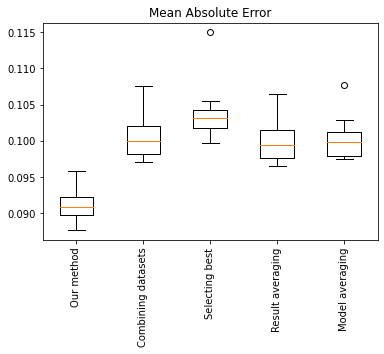

In [19]:
plt.boxplot([ maes_our, maes_cd,  maes_sb_gdsc, maes_wa, maes_ma])
plt.title("Mean Absolute Error")
plt.xticks([1, 2, 3, 4, 5], ['Our method', 'Combining datasets', 'Selecting best', 'Result averaging', 'Model averaging'])
plt.xticks(rotation = 90)
plt.savefig(out_path+'mean_absolute_error_boxplots_cv.png', dpi=300, bbox_inches= 'tight')
plt.show()

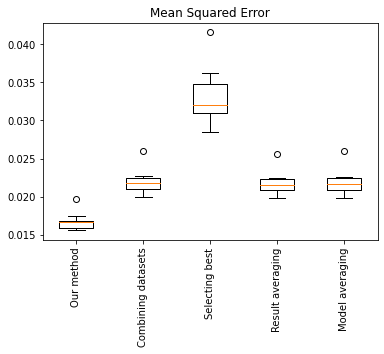

In [20]:
plt.boxplot([mses_our, mses_cd,  mses_sb_gdsc, mses_wa, mses_ma])
plt.title("Mean Squared Error")
plt.xticks([1, 2, 3, 4, 5], ['Our method', 'Combining datasets', 'Selecting best', 'Result averaging', 'Model averaging'])
plt.xticks(rotation = 90)
plt.savefig(out_path+'mean_squared_error_boxplots_cv.png', dpi=300, bbox_inches= 'tight')
plt.show()

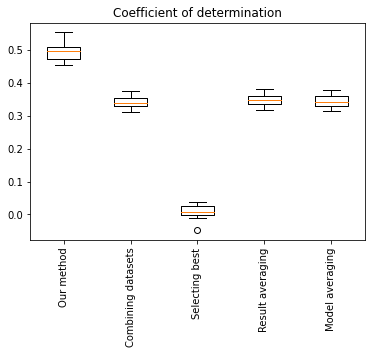

In [21]:
plt.boxplot([r2s_our, r2s_cd,  r2s_sb_gdsc, r2s_wa, r2s_ma])
plt.title("Coefficient of determination")
plt.xticks([1, 2, 3, 4, 5], ['Our method', 'Combining datasets', 'Selecting best', 'Result averaging', 'Model averaging'])
plt.xticks(rotation = 90)
plt.savefig(out_path+'r2_boxplots_cv.png', dpi=300, bbox_inches= 'tight')
plt.show()

For SB, ccle is worse. So, we keep gdsc.